# This is due 10 November 2024

Assume Barberis, Huang, and Santos economy where investor receives utility from consumption as well as recent financial gain or loss. Use these parameters:

delta = 0.99, gamma = 1, lambda = 2

Consumption growth has lognormal distribution:

lng = 0.02 + 0.02ε

where ε is standard normal random variable. Simulate probability distribution for consumption growth with (at least) 104 random draws from standard normal distribution.

With these parameters, risk-free rate is around 3% per year:

Rf = e^0.0198 / 0.99 = 1.0303

Define x as one plus dividend yield for market portfolio:

 x = (1 + P / D) * D / P = 1 + D / P

and define error term:

e(x) = 0.99bE[v(xg)] + 0.99x - 1

where utility from recent financial gain or loss is given by:

v(R) = R - 1.0303 for R >= 1.0303

v(R) = 2(R - 1.0303) for R < 1.0303

Solve for e(x) = 0 to find equilibrium value of x, using bisection search:

1.) Set x– = 1 and x+ = 1.1, and use simulated distribution of consumption growth to confirm that e(x–) < 0 and e(x+) > 0 ⇒ solution must lie between x– and x+

2.) Set x0 = 0.5*(x– + x+) and use simulated distribution of consumption growth to calculate e(x0)

3.) If |e(x0)| < 10–5, then you have converged to solution

4.) Otherwise if e(x0) < 0, then solution lies between x0 and x+ ⇒ repeat from step 2 with x– = x0

5.) Otherwise if e(x0) > 0, then solution lies between x– and x0 ⇒ repeat from step 2 with x+ = x0

6.) Repeat for b0 in range from 0 to 10, in increments of 0.1 (or less).

Calculate price-dividend ratio for market portfolio:

P / D = 1 / (x - 1)
 
Plot price-dividend ratio (on vertical axis) vs b0.

Calculate expected market return:

E(Rm) = E(xg) = xe^0.0202

Plot equity premium (on vertical axis) vs b0.

Briefly describe (in words, without using mathematical equations or formulas) main characteristics of v(∙) (which is utility function to measure utility from recent financial gain or loss) as well as economic significance and implications of b0 and λ.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot, scatter, plot, axis
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Datetime
import datetime as dt
from datetime import datetime
from datetime import timedelta

import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# initialize variables
n_simulations = 100000

In [4]:
delta = 0.99  # Discount factor
gamma = 1     # Coefficient of relative risk aversion
lamda = 2     # Degree of loss aversion

In [5]:
random_epsilon = np.random.normal(0, 1)

In [6]:
# Note: This assumes that consumption grows at 2% a year with a standard deviation of 2%

def consumption_growth (epsilon):
    growth = np.exp(0.02 + 0.02*epsilon)
    return growth

In [7]:
columns = ["epsilon",
           "growth",]

In [8]:
# Create dataframe to store simulation results

Simulation_df = pd.DataFrame(index=range(n_simulations), columns=columns)

Simulation_df["epsilon"] = np.random.normal(0, 1, (n_simulations))

Simulation_df["growth"] = consumption_growth (Simulation_df["epsilon"])

In [9]:
Simulation_df

,epsilon,growth
0,-1.372894,0.992570
1,-0.067157,1.018832
2,1.524152,1.051779
3,0.316026,1.026670
4,-0.755191,1.004908
...,...,...
99995,1.110780,1.043119
99996,0.286964,1.026073
99997,0.545193,1.031386
99998,1.733978,1.056202


In [10]:
# See Slide 8

rf = 1 / (delta * np.mean(np.array(Simulation_df["growth"]) ** - gamma))

In [11]:
rf

1.03028978274219

In [12]:
# See Slide 6

def expected_utility_calc(kappa, g):

    # https://numpy.org/doc/2.1/reference/generated/numpy.where.html
    Eu = \
        np.mean(
            np.where(
                kappa * g >= 1.0303,       # If return higher than risk-free rate
                kappa * g - 1.0303,        # Utility is just return minus risk free rate
                2 * (kappa * g - 1.0303)   # Otherwise, utility is twice as impacted
            )
        )

    return Eu

In [13]:
def error(b, utility, kappa):

    err = 0.99 * b * utility + 0.99 * kappa - 1
    
    return err

In [14]:
b =  \
    np \
        .linspace(
            start = 0, 
            stop = 10, 
            num = 1001
        )

In [15]:
b

array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ])

In [16]:
kappa_results = []

for i in b:
    
    # confirm that solution lies between start and end
    start = 1
    end = 1.1

    # https://numpy.org/devdocs/reference/generated/numpy.full.html
    start_utility = \
        expected_utility_calc(
            kappa = np.full((1, n_simulations), start), 
            g = Simulation_df["growth"].values
            )
    
    end_utility = \
        expected_utility_calc(
            kappa = np.full((1, n_simulations), end), 
            g = Simulation_df["growth"].values
        )

    if (error(i, start_utility, start) * error(i, end_utility, end)) > 0:
    
        print('solution does not lie between kappa_ and kappa+')

    error_term = 999

    # bisection search, while absolute of error term greater than
    while abs(error_term) > 10e-5:

        # set kappa as mid of start and end
        kappa0_single = 0.5 * (start + end)

        # create array of kappa to multiply with simulated consumption growth
        kappa0 = np.full((1, n_simulations), kappa0_single)

        # calculate the E(v(kappa * g))
        Eu = expected_utility_calc(kappa = kappa0,
                                   g = Simulation_df["growth"].values)

        # calculate error term
        error_term = error(b = i,
                           utility = Eu, 
                           kappa = kappa0_single)

        # if error term < 0 means kappa < answer < 1.1
        if error_term < 0:

            start = kappa0_single

        # if error term > 0 means 1 < answer < kappa
        if error_term > 0:
            
            end = kappa0_single

        # if error term converge than thats the kappa
        if abs(error_term) < 10e-5:

            kappa_results.append(kappa0_single)

In [17]:
kappa_results

[1.0101562499999999,
 1.0101562499999999,
 1.0101562499999999,
 1.0103515625,
 1.0103515625,
 1.0105468749999997,
 1.0105468749999997,
 1.0105468749999997,
 1.0106445312499996,
 1.0107421874999998,
 1.0107421874999998,
 1.0107421874999998,
 1.0109374999999998,
 1.0109374999999998,
 1.0109374999999998,
 1.0110351562499997,
 1.0111328124999999,
 1.0111328124999999,
 1.0111328124999999,
 1.01123046875,
 1.011328125,
 1.011328125,
 1.011328125,
 1.0114257812499998,
 1.0115234375,
 1.0115234375,
 1.0115234375,
 1.0115234375,
 1.01162109375,
 1.01162109375,
 1.01171875,
 1.01171875,
 1.01171875,
 1.01181640625,
 1.01181640625,
 1.0119140625,
 1.0119140625,
 1.0119140625,
 1.0119140625,
 1.0120117187500002,
 1.0120117187500002,
 1.0120117187500002,
 1.012109375,
 1.012109375,
 1.012109375,
 1.012109375,
 1.01220703125,
 1.01220703125,
 1.01220703125,
 1.0123046875,
 1.0123046875,
 1.0123046875,
 1.0123046875,
 1.0124023437499998,
 1.0124023437499998,
 1.0124023437499998,
 1.0124023437499998,


In [18]:
# creating df 
df = pd.DataFrame(kappa_results).rename(columns = {0 : 'kappa'})

df['b'] = b

In [19]:
df

,kappa,b
0,1.010156,0.00
1,1.010156,0.01
2,1.010156,0.02
3,1.010352,0.03
4,1.010352,0.04
...,...,...
996,1.014978,9.96
997,1.014978,9.97
998,1.014978,9.98
999,1.014978,9.99


# Calculate price-dividend ratio for market portfolio:

#### P / D = 1 / (x - 1)
 
#### Plot price-dividend ratio (on vertical axis) vs b0.

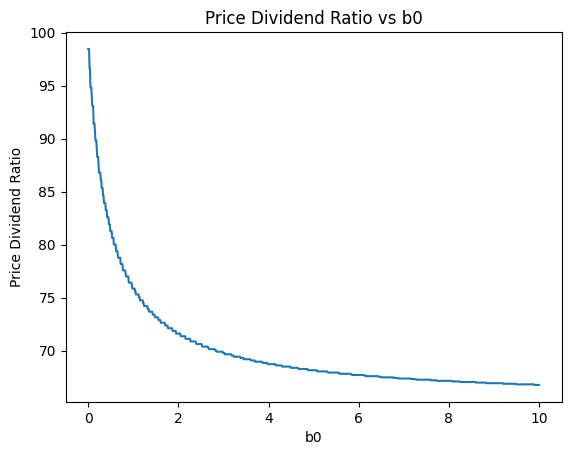

In [20]:
# plotting price dividend ratio

df['price_dividend_ratio'] = 1 / (df.kappa - 1)

plt.plot(
    df.b, 
    df.price_dividend_ratio
    )

plt \
    .xlabel('b0')

plt \
    .ylabel('Price Dividend Ratio')

plt \
    .title('Price Dividend Ratio vs b0');

## Calculate expected market return:

#### E(Rm) = E(xg) = xe^0.0202

#### Plot equity premium (on vertical axis) vs b0.

In [21]:
#plotting equity premium
Rf = \
    np.exp(0.0198) / 0.99

df['expected_market_return'] = df.kappa * np.exp(0.0202)        # Expected market return

# Deduct rf from equity return to get equity risk premium
df['equity_premiunn'] = df['expected_market_return'] - Rf       # Equity risk premium

In [22]:
df

,kappa,b,price_dividend_ratio,expected_market_return,equity_premiunn
0,1.010156,0.00,98.461538,1.030769,0.000469
1,1.010156,0.01,98.461538,1.030769,0.000469
2,1.010156,0.02,98.461538,1.030769,0.000469
3,1.010352,0.03,96.603774,1.030968,0.000668
4,1.010352,0.04,96.603774,1.030968,0.000668
...,...,...,...,...,...
996,1.014978,9.96,66.764466,1.035689,0.005389
997,1.014978,9.97,66.764466,1.035689,0.005389
998,1.014978,9.98,66.764466,1.035689,0.005389
999,1.014978,9.99,66.764466,1.035689,0.005389


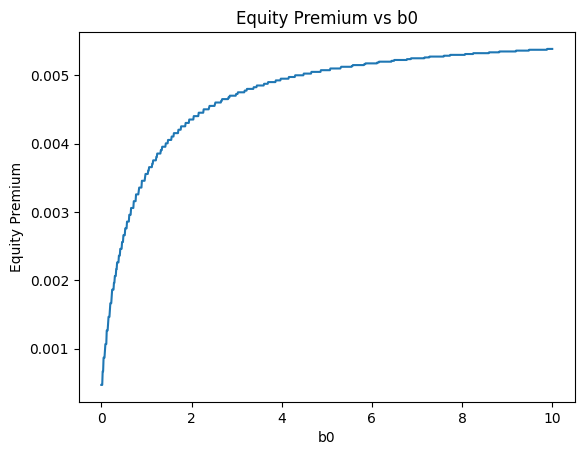

In [23]:
# Deduct rf from equity return to get equity risk premium
plt.plot(df["b"], df['equity_premiunn'])

plt \
    .xlabel('b0')

plt \
    .ylabel('Equity Premium')

plt \
    .title('Equity Premium vs b0');

## Briefly explain main characteristics of v(∙) (which is utility function to measure utility from recent financial gain or loss), as well as economic significance of b0 and λ.

v(∙) represents utility from recent financial gain or loss, it is a piecewise-linear function where utility from gain and loss are defined by 2 functions, one for gain, the other for loss. The function for loss is scaled by the degree of loss aversion (λ), such that the utility decrease from a loss is more than the utility increase from a gain of the same magnitude. Whether the return obtained is considered a gain or loss is measured relative to a reference level based on risk-free rate. 

b0 is the scale factor that ensures that the amount of utility from consumption remains similar to amount of utility from recent gain or loss. In other words, b0 determines the extent to which utility from recent financial gains or losses contribute to an investor's lifetime utility. If b0 equals to 0, investors utility is not impacted by recent gain or loss, and prospect theory is not relavant. For high values of b0, heavy weight is given to the recent financial gains or losses in contributing to an investor's lifetime utility. As b0 increases, equity risk premium should increase at a decreasing rate (concave). However, even at high values of b0, equity risk premium is still too low under  prospect theory for reasonable levels of risk aversion and loss aversion.

λ is the degree of loss aversion. As investors are more sensitive to shortfall in financial gain (or outright financial loss), λ is more than 1 and is around 2 in real-life. This means that investors are more sensitive to downside risk, and a loss would result in a reduction of utility that is twice as large (when λ = 2), compared to the increase in utility from a gain of the same magnitude. 